In [1]:
import copy
import glob
import pickle
import warnings
from datetime import datetime, timedelta
from itertools import product
import joblib
import os
import numpy as np
import xarray as xr
import pandas as pd
import copy
from datetime import datetime, timedelta
from keras.utils import to_categorical
# import visualkeras
# import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
import optuna
from optuna.samplers import TPESampler
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader

import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
# np.random.seed(42)
import pandas as pd
import shapely.geometry as sgeom
import xarray as xr
from scipy import stats
from scipy.spatial.distance import cdist
from shapely import geometry
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


2023-08-22 07:39:47.602618: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# def create_tf_datasets(input_data, output_data):
#     # Convert xarray dataset to numpy array for TensorFlow Dataset
#     input_images = input_data.transpose('time', 'lat', 'lon','channel').values
#     output_one_hot = output_data.values

#     # Create TensorFlow Datasets
#     input_dataset = tf.data.Dataset.from_tensor_slices(input_images)
#     output_dataset = tf.data.Dataset.from_tensor_slices(output_one_hot)

#     # Combine input and output datasets into a joint dataset
#     joint_dataset = tf.data.Dataset.zip((input_dataset, output_dataset))

#     return joint_dataset
def create_tf_datasets(input_data, output_data):
    # Convert xarray dataset to numpy array for TensorFlow Dataset
    input_images = input_data.transpose('time', 'lat', 'lon','channel').values
    output_one_hot = output_data.values

    # Create TensorFlow Datasets
    input_dataset = tf.data.Dataset.from_tensor_slices(input_images)
    output_dataset = tf.data.Dataset.from_tensor_slices(output_one_hot)

    # Combine input and output datasets into a joint dataset
    joint_dataset = tf.data.Dataset.zip((input_dataset, output_dataset))

    return (input_images,output_one_hot)

def create_datasets(input_anoms, var_name, df_shifts, week_out):
# Assuming you have the xarray.Dataset 'input_data' and the pandas.Series 'output_data'
    input_data = copy.deepcopy(input_anoms[var_name])

    array_temp = input_data.data
    array_temp[np.isfinite(array_temp)==False]=0
    input_data.data = array_temp

#     input_data = (input_data - input_data.mean('time')) / (input_data.std('time'))
    
#     input_data[np.isfinite(array_temp)==False] = 0
    
    # Reshape the data to add a new dimension
    values_reshaped = input_data.values.reshape(input_data.shape[0], input_data.shape[1], input_data.shape[2], 1)

    # Create a new xarray.DataArray with the reshaped data and the original coordinates
    input_data = xr.DataArray(values_reshaped, coords=input_data.coords, dims=('time', 'lat', 'lon', 'channel'))
    output_data = copy.deepcopy(df_shifts[f'week{week_out}']).dropna()

    # Step 1: Create a common date index that includes all dates in both the input and output data
    common_dates = np.intersect1d(input_data['time'].values, output_data.index)

    # Step 2: Reindex the input xarray dataset and the output DataFrame to the common date index
    input_data = input_data.sel(time=common_dates)
    output_data = output_data.loc[common_dates]

    # Step 3: One-hot encode the output DataFrame using to_categorical
    num_classes = len(output_data.unique())  # Number of classes (number of weeks in this case)
    output_data_encoded = to_categorical(output_data, num_classes=num_classes)
    output_data_encoded = pd.DataFrame(output_data_encoded,index=output_data.index)

    # Step 4: Create masks for training, validation, and testing periods
    train_mask = (output_data.index >= '1980-01-01') & (output_data.index <= '2010-12-31')
    val_mask = (output_data.index >= '2011-01-01') & (output_data.index <= '2015-12-31')
    test_mask = (output_data.index >= '2016-01-01') & (output_data.index <= '2020-12-31')

    # Step 5: Split the input xarray dataset and the output DataFrame into subsets
    input_train = input_data.sel(time=train_mask)
    input_val = input_data.sel(time=val_mask)
    input_test = input_data.sel(time=test_mask)

    output_train = output_data_encoded.loc[train_mask]
    output_val = output_data_encoded.loc[val_mask]
    output_test = output_data_encoded.loc[test_mask]

    train_joint_dataset = create_tf_datasets(input_train, output_train)
    val_joint_dataset = create_tf_datasets(input_val, output_val)
    test_joint_dataset = create_tf_datasets(input_test, output_test)

    # buffer_size = train_joint_dataset.cardinality()
    # train_joint_dataset = train_joint_dataset.shuffle(buffer_size)
    return train_joint_dataset, val_joint_dataset, test_joint_dataset,input_train.time,\
        input_val.time,input_test.time

def get_output_from_dataset(dataset):
    output_array = []
    for input_data, output_data in dataset.as_numpy_iterator():
        output_array.append(output_data)

    # Convert the list of NumPy arrays into a single NumPy array
    output_array = np.array(output_array)
    return output_array

def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(balanced_accuracy_score, (y_true, y_pred), tf.float32)

def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [3]:
sys.path.append("/glade/u/home/jhayron/WR_Predictability/3_MLModels/")
from model_builders import *

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## GLOBAL SEED ##    
np.random.seed(42)
tf.random.set_seed(42)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-08-22 07:40:03.438805: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-22 07:40:03.440256: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-08-22 07:40:03.487765: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:89:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-08-22 07:40:03.487806: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-08-22 07:40:03.593876: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-08-22 07:40:03.593918: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [5]:
dict_params = {'model_base':'inception',
               'type_pooling':'avg',
               'do':0.7,
               'md':8,
               'activation':'LeakyReLU',
               'weighted_loss':True,
               'bs':32,
               'lr':0.001} 

In [6]:
for name_var in ['IT_SODA', 'OHC100_SODA', 'SD_ERA5', 'STL_full_ERA5', 'SWVL_full_ERA5', 'Z500_ERA5',
                 'MLD_SODA', 'OLR_ERA5', 'SST_SODA', 'SWVL_28cm_ERA5', 'U200_ERA5']:
    path_models = '/glade/work/jhayron/Data4Predictability/models/CNN_Aug21_2023/v0/'
    path_weekly_anoms = '/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/'
    # path_weekly_anoms = '/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_Std_withTrends/'
    input_anoms = xr.open_dataset(f'{path_weekly_anoms}{name_var}.nc')

    wr_series = pd.read_csv('/glade/work/jhayron/Data4Predictability/WR_Series_20230815_v2.csv',\
                    index_col=0,names=['week0'],skiprows=1,parse_dates=True)
    for wk in range(2,10):
        series_temp = copy.deepcopy(wr_series["week0"])
        series_temp.index = series_temp.index - timedelta(weeks = wk-1)
        series_temp.name = f'week{wk-1}'
        if wk==2:
            df_shifts = pd.concat([pd.DataFrame(wr_series["week0"]),pd.DataFrame(series_temp)],
                                  axis=1)  
        else:
            df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)
            
    for week_out in [0,1,2,3,4,5,6,7,8]:
        print(name_var,week_out)
        var_name = list(input_anoms.data_vars.keys())[0]
        week_out_str = f'week{week_out}'

        train_joint_dataset, val_joint_dataset, test_joint_dataset, _, _, test_index = \
            create_datasets(input_anoms, var_name, df_shifts, week_out)

        model = build_inception_model(dict_params['type_pooling'],
                                 dict_params['do'],
                                 dict_params['md'],
                                 dict_params['activation'])
        model.compile(loss=keras.losses.categorical_crossentropy, 
                              optimizer=keras.optimizers.Adam(lr=dict_params['lr']),
                              metrics=[balanced_accuracy,'accuracy']) 
        filepath = f'{path_models}{name_var}/model_{week_out_str}_v0.h5'

        model.load_weights(filepath)

        predictions_prob = model.predict(test_joint_dataset[0])
        predictions = predictions_prob.argmax(axis=1)
        wr_temp = test_joint_dataset[1].argmax(1)

        df_results = pd.DataFrame(np.array([predictions,wr_temp]).T,
                                  index=pd.to_datetime(test_index),
                                  columns=['forecast','true'])
        df_results['month'] = df_results.index.month
        df_results['initial_wr'] = df_shifts.week0.loc[df_results.index].astype(int)

        acc = accuracy_score(df_results['true'],df_results['forecast'])
        acc_persistence = accuracy_score(df_results['true'],df_results['initial_wr'])
        
        acc_months = []
        acc_months_persistence = []
        # for month in [2,5,8,11]:
        for month in range(1,13):
            # df_temp = df_results[(df_results['month']<=month+1)&(df_results['month']>=month-1)]
            df_temp = df_results[df_results['month']==month]
            acc_months.append(accuracy_score(df_temp['true'],df_temp['forecast']))
            acc_months_persistence.append(accuracy_score(df_temp['true'],df_temp['initial_wr']))

        acc_init_wr = []
        acc_init_wr_persistence = []
        for wr in range(0,5):
            df_temp = df_results[df_results['initial_wr']==wr]
            acc_init_wr.append(accuracy_score(df_temp['true'],df_temp['forecast']))
            acc_init_wr_persistence.append(accuracy_score(df_temp['true'],df_temp['initial_wr']))

        acc_final_wr = []
        acc_final_wr_persistence = []
        for wr in range(0,5):
            df_temp = df_results[df_results['true']==wr]
            acc_final_wr.append(accuracy_score(df_temp['true'],df_temp['forecast']))
            acc_final_wr_persistence.append(accuracy_score(df_temp['true'],df_temp['initial_wr']))

        dic_performance={}
        dic_performance['acc'] = acc
        dic_performance['acc_persistence'] = acc_persistence
        dic_performance['acc_months'] = acc_months
        dic_performance['acc_months_persistence'] = acc_months_persistence
        
        dic_performance['acc_init_wr'] = acc_init_wr
        dic_performance['acc_init_wr_persistence'] = acc_init_wr_persistence
        
        dic_performance['acc_final_wr'] = acc_final_wr
        dic_performance['acc_final_wr_persistence'] = acc_final_wr_persistence

        np.save(f'dics_performance/dic_{name_var}_{week_out_str}.npy',dic_performance)

IT_SODA 0


2023-08-22 07:48:40.682955: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 07:48:40.683630: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-22 07:48:40.684215: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:89:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-08-22 07:48:40.684261: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-08-22 07:48:40.684292: I tensorflow/stream_executor/platfor

IT_SODA 1
IT_SODA 2
IT_SODA 3
IT_SODA 4
IT_SODA 5
IT_SODA 6
IT_SODA 7
IT_SODA 8
OHC100_SODA 0
OHC100_SODA 1
OHC100_SODA 2
OHC100_SODA 3
OHC100_SODA 4
OHC100_SODA 5
OHC100_SODA 6
OHC100_SODA 7
OHC100_SODA 8
SD_ERA5 0
SD_ERA5 1
SD_ERA5 2
SD_ERA5 3
SD_ERA5 4
SD_ERA5 5
SD_ERA5 6
SD_ERA5 7
SD_ERA5 8
STL_full_ERA5 0
STL_full_ERA5 1
STL_full_ERA5 2
STL_full_ERA5 3
STL_full_ERA5 4
STL_full_ERA5 5
STL_full_ERA5 6
STL_full_ERA5 7
STL_full_ERA5 8
SWVL_full_ERA5 0
SWVL_full_ERA5 1
SWVL_full_ERA5 2
SWVL_full_ERA5 3
SWVL_full_ERA5 4
SWVL_full_ERA5 5
SWVL_full_ERA5 6
SWVL_full_ERA5 7
SWVL_full_ERA5 8
Z500_ERA5 0
Z500_ERA5 1
Z500_ERA5 2
Z500_ERA5 3
Z500_ERA5 4
Z500_ERA5 5
Z500_ERA5 6
Z500_ERA5 7
Z500_ERA5 8
MLD_SODA 0
MLD_SODA 1
MLD_SODA 2
MLD_SODA 3
MLD_SODA 4
MLD_SODA 5
MLD_SODA 6
MLD_SODA 7
MLD_SODA 8
OLR_ERA5 0
OLR_ERA5 1
OLR_ERA5 2
OLR_ERA5 3
OLR_ERA5 4
OLR_ERA5 5
OLR_ERA5 6
OLR_ERA5 7
OLR_ERA5 8
SST_SODA 0
SST_SODA 1
SST_SODA 2
SST_SODA 3
SST_SODA 4
SST_SODA 5
SST_SODA 6
SST_SODA 7
SST_SODA 8
SW

OSError: Unable to open file (unable to open file: name = '/glade/work/jhayron/Data4Predictability/models/CNN_Aug21_2023/v0/U200_ERA5/model_week8_v0.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [7]:
for name_var in ['IT_SODA', 'OHC100_SODA', 'SD_ERA5', 'STL_full_ERA5', 'SWVL_full_ERA5', 'Z500_ERA5',
                 'MLD_SODA', 'OLR_ERA5', 'SST_SODA', 'SWVL_28cm_ERA5', 'U200_ERA5']:
    path_models = '/glade/work/jhayron/Data4Predictability/models/CNN_Aug21_2023/v0/'
    path_weekly_anoms = '/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/'
    # path_weekly_anoms = '/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_Std_withTrends/'
    input_anoms = xr.open_dataset(f'{path_weekly_anoms}{name_var}.nc')

    wr_series = pd.read_csv('/glade/work/jhayron/Data4Predictability/WR_Series_20230815_v2.csv',\
                    index_col=0,names=['week0'],skiprows=1,parse_dates=True)
    for wk in range(2,10):
        series_temp = copy.deepcopy(wr_series["week0"])
        series_temp.index = series_temp.index - timedelta(weeks = wk-1)
        series_temp.name = f'week{wk-1}'
        if wk==2:
            df_shifts = pd.concat([pd.DataFrame(wr_series["week0"]),pd.DataFrame(series_temp)],
                                  axis=1)  
        else:
            df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)
            
    for week_out in [0,1,2,3,4,5,6,7,8]:
        print(name_var,week_out)
        var_name = list(input_anoms.data_vars.keys())[0]
        week_out_str = f'week{week_out}'

        train_joint_dataset, val_joint_dataset, test_joint_dataset, _, _, test_index = \
            create_datasets(input_anoms, var_name, df_shifts, week_out)

        model = build_inception_model(dict_params['type_pooling'],
                                 dict_params['do'],
                                 dict_params['md'],
                                 dict_params['activation'])
        model.compile(loss=keras.losses.categorical_crossentropy, 
                              optimizer=keras.optimizers.Adam(lr=dict_params['lr']),
                              metrics=[balanced_accuracy,'accuracy']) 
        filepath = f'{path_models}{name_var}/model_{week_out_str}_v0.h5'

        model.load_weights(filepath)

        predictions_prob = model.predict(test_joint_dataset[0])
        predictions = predictions_prob.argmax(axis=1)
        wr_temp = test_joint_dataset[1].argmax(1)

        df_results = pd.DataFrame(np.array([predictions,wr_temp]).T,
                                  index=pd.to_datetime(test_index),
                                  columns=['forecast','true'])
        df_results['month'] = df_results.index.month
        df_results['initial_wr'] = df_shifts.week0.loc[df_results.index].astype(int)

        acc = balanced_accuracy_score(df_results['true'],df_results['forecast'])
        acc_persistence = balanced_accuracy_score(df_results['true'],df_results['initial_wr'])
        
        acc_months = []
        acc_months_persistence = []
        # for month in [2,5,8,11]:
        for month in range(1,13):
            # df_temp = df_results[(df_results['month']<=month+1)&(df_results['month']>=month-1)]
            df_temp = df_results[df_results['month']==month]
            acc_months.append(balanced_accuracy_score(df_temp['true'],df_temp['forecast']))
            acc_months_persistence.append(balanced_accuracy_score(df_temp['true'],df_temp['initial_wr']))

        acc_init_wr = []
        acc_init_wr_persistence = []
        for wr in range(0,5):
            df_temp = df_results[df_results['initial_wr']==wr]
            acc_init_wr.append(balanced_accuracy_score(df_temp['true'],df_temp['forecast']))
            acc_init_wr_persistence.append(balanced_accuracy_score(df_temp['true'],df_temp['initial_wr']))

        acc_final_wr = []
        acc_final_wr_persistence = []
        for wr in range(0,5):
            df_temp = df_results[df_results['true']==wr]
            acc_final_wr.append(balanced_accuracy_score(df_temp['true'],df_temp['forecast']))
            acc_final_wr_persistence.append(balanced_accuracy_score(df_temp['true'],df_temp['initial_wr']))

        dic_performance={}
        dic_performance['acc'] = acc
        dic_performance['acc_persistence'] = acc_persistence
        dic_performance['acc_months'] = acc_months
        dic_performance['acc_months_persistence'] = acc_months_persistence
        
        dic_performance['acc_init_wr'] = acc_init_wr
        dic_performance['acc_init_wr_persistence'] = acc_init_wr_persistence
        
        dic_performance['acc_final_wr'] = acc_final_wr
        dic_performance['acc_final_wr_persistence'] = acc_final_wr_persistence

        np.save(f'dics_performance_v2/dic_{name_var}_{week_out_str}.npy',dic_performance)

IT_SODA 0
IT_SODA 1
IT_SODA 2
IT_SODA 3
IT_SODA 4
IT_SODA 5
IT_SODA 6
IT_SODA 7
IT_SODA 8
OHC100_SODA 0
OHC100_SODA 1
OHC100_SODA 2
OHC100_SODA 3
OHC100_SODA 4
OHC100_SODA 5
OHC100_SODA 6
OHC100_SODA 7
OHC100_SODA 8
SD_ERA5 0
SD_ERA5 1
SD_ERA5 2
SD_ERA5 3
SD_ERA5 4
SD_ERA5 5
SD_ERA5 6
SD_ERA5 7
SD_ERA5 8
STL_full_ERA5 0
STL_full_ERA5 1
STL_full_ERA5 2
STL_full_ERA5 3
STL_full_ERA5 4
STL_full_ERA5 5
STL_full_ERA5 6
STL_full_ERA5 7
STL_full_ERA5 8
SWVL_full_ERA5 0
SWVL_full_ERA5 1
SWVL_full_ERA5 2
SWVL_full_ERA5 3
SWVL_full_ERA5 4
SWVL_full_ERA5 5
SWVL_full_ERA5 6
SWVL_full_ERA5 7
SWVL_full_ERA5 8
Z500_ERA5 0
Z500_ERA5 1
Z500_ERA5 2
Z500_ERA5 3
Z500_ERA5 4
Z500_ERA5 5
Z500_ERA5 6
Z500_ERA5 7
Z500_ERA5 8
MLD_SODA 0
MLD_SODA 1
MLD_SODA 2
MLD_SODA 3
MLD_SODA 4
MLD_SODA 5
MLD_SODA 6
MLD_SODA 7
MLD_SODA 8
OLR_ERA5 0
OLR_ERA5 1
OLR_ERA5 2
OLR_ERA5 3
OLR_ERA5 4
OLR_ERA5 5
OLR_ERA5 6
OLR_ERA5 7
OLR_ERA5 8
SST_SODA 0
SST_SODA 1
SST_SODA 2
SST_SODA 3
SST_SODA 4
SST_SODA 5
SST_SODA 6
SST_SODA 7
SST

OSError: Unable to open file (unable to open file: name = '/glade/work/jhayron/Data4Predictability/models/CNN_Aug21_2023/v0/U200_ERA5/model_week8_v0.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [191]:
np.load(f'dics_performance/dic_{name_var}_{week_out_str}.npy',allow_pickle=True)[()]

{'acc': 0.2250996015936255,
 'acc_months': [0.20454545454545456,
  0.24390243902439024,
  0.36363636363636365,
  0.3488372093023256,
  0.20454545454545456,
  0.046511627906976744,
  0.13636363636363635,
  0.28888888888888886,
  0.21428571428571427,
  0.20930232558139536,
  0.2647058823529412,
  0.17142857142857143],
 'acc_init_wr': [0.2980769230769231,
  0.14893617021276595,
  0.2356687898089172,
  0.20430107526881722,
  0.2222222222222222],
 'acc_final_wr': [0.05714285714285714,
  0.0,
  0.21710526315789475,
  0.7628865979381443,
  0.0]}

In [179]:
acc = accuracy_score(df_results['true'],df_results['forecast'])

acc_months = []
# for month in [2,5,8,11]:
for month in range(1,13):
    # df_temp = df_results[(df_results['month']<=month+1)&(df_results['month']>=month-1)]
    df_temp = df_results[df_results['month']==month]
    acc_months.append(accuracy_score(df_temp['true'],df_temp['forecast']))

acc_init_wr = []
for wr in range(0,5):
    df_temp = df_results[df_results['initial_wr']==wr]
    acc_init_wr.append(accuracy_score(df_temp['true'],df_temp['forecast']))
    
acc_final_wr = []
for wr in range(0,5):
    df_temp = df_results[df_results['true']==wr]
    acc_final_wr.append(accuracy_score(df_temp['true'],df_temp['forecast']))

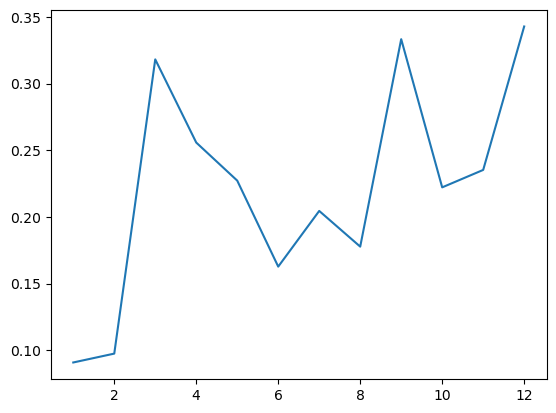

In [165]:
plt.plot(range(1,13),acc_months)

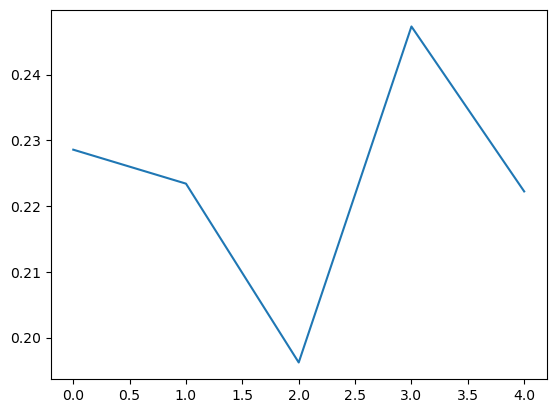

In [170]:
plt.plot(acc_init_wr)

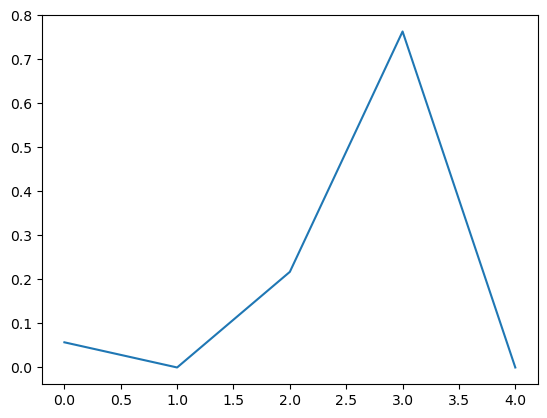

In [180]:
plt.plot(acc_final_wr)

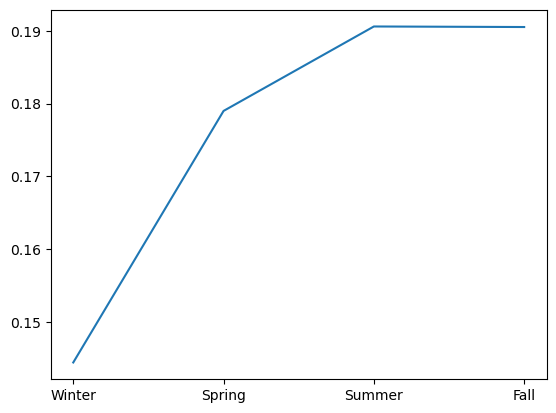

In [159]:
plt.plot(['Winter','Spring','Summer','Fall'],bal_acc_months)
# plt.plot(['Winter','Spring','Summer','Fall'],acc_months)

In [118]:
bal_acc_months

[0.16]

In [102]:
acc_months

[0.7954545454545454,
 0.7073170731707317,
 0.75,
 0.7209302325581395,
 0.8863636363636364,
 0.7906976744186046,
 0.75,
 0.8222222222222222,
 0.7619047619047619,
 0.7555555555555555,
 0.8809523809523809,
 0.7428571428571429]

In [61]:
df_results

,0,1,month,initial_wr
2016-01-04,2,2,1,2
2016-01-07,1,2,1,2
2016-01-11,1,1,1,1
2016-01-14,1,2,1,2
2016-01-18,2,2,1,2
...,...,...,...,...
2020-11-12,1,1,11,1
2020-11-16,2,2,11,2
2020-11-19,3,3,11,3
2020-11-23,3,3,11,3


2016-01-04    2.0
2016-01-07    2.0
2016-01-11    1.0
2016-01-14    2.0
2016-01-18    2.0
             ... 
2020-11-12    1.0
2020-11-16    2.0
2020-11-19    3.0
2020-11-23    3.0
2020-11-26    3.0
Name: week0, Length: 512, dtype: float64

In [41]:
predictions

array([2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 1, 1, 0, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 3, 0, 0, 2, 3, 0, 0, 4, 0,
       2, 0, 0, 0, 3, 0, 4, 1, 1, 0, 0, 0, 0, 2, 0, 0, 3, 3, 4, 1, 0, 0,
       0, 0, 0, 0, 0, 2, 4, 1, 4, 0, 0, 2, 2, 2, 1, 1, 0, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 1, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 3, 3, 1, 1,
       1, 2, 0, 0, 0, 3, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 3,
       0, 0, 0, 3, 1, 2, 2, 4, 1, 1, 3, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0, 1,
       1, 3, 3, 3, 0, 2, 0, 0, 2, 2, 0, 0, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3,
       3, 1, 0, 2, 0, 3, 2, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 3,
       3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 3, 0, 0, 0, 2, 2, 1, 1, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 3, 3, 1, 3, 3, 0, 3, 3, 3,
       0, 0, 2, 2, 2, 2, 2, 3, 2, 2, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 2, 2, 2, 3, 3, 3, 0, 0, 0, 2, 2, 2, 2, 2,

array([2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 0, 0, 4, 0,
       4, 0, 0, 3, 3, 3, 4, 1, 1, 4, 0, 0, 2, 2, 0, 0, 4, 4, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 2, 4, 1, 4, 0, 2, 2, 2, 2, 4, 1, 0, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 1, 0, 0, 0, 1, 1, 1, 1, 3, 0, 0, 0, 3, 3, 1, 1,
       1, 2, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 4, 4,
       3, 3, 3, 4, 1, 2, 2, 4, 1, 1, 4, 2, 2, 1, 1, 2, 2, 2, 1, 1, 4, 1,
       1, 1, 4, 4, 4, 4, 0, 0, 2, 2, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       4, 1, 0, 2, 0, 3, 3, 2, 2, 2, 1, 2, 3, 3, 0, 0, 0, 0, 0, 0, 2, 3,
       3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 4, 4, 0, 0, 0, 0, 3, 2,
       2, 2, 2, 0, 0, 4, 2, 2, 3, 4, 4, 4, 0, 0, 2, 2, 2, 2, 2, 2, 3, 3,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 4, 3, 3, 3, 3, 0, 3, 3, 3,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 0, 0, 0, 0, 0, 2, 0, 0, 3, 3,
       3, 2, 2, 2, 3, 3, 3, 4, 1, 2, 2, 2, 2, 2, 2,

In [27]:
test_joint_dataset[0].shape

(512, 240, 720, 1)

In [26]:
df_shifts['week0'].dropna()

1981-01-05    3.0
1981-01-08    3.0
1981-01-12    3.0
1981-01-15    3.0
1981-01-19    3.0
             ... 
2020-11-12    1.0
2020-11-16    2.0
2020-11-19    3.0
2020-11-23    3.0
2020-11-26    3.0
Name: week0, Length: 4164, dtype: float64